Init

In [1]:
import pyhilbert
import sympy as sy
from sympy import ImmutableDenseMatrix
import numpy as np

# Display sympy expressions nicely
sy.init_printing(use_unicode=True) 

# Building a 3D Simple Cubic Lattice System

This notebook demonstrates how to construct a simple cubic lattice tight-binding system in real space using PyHilbert.

## Key Steps:
1. Define the simple cubic lattice
2. Create a single atom basis (or 2-atom basis for comparison)
3. Define orbital and spin degrees of freedom
4. Build the Hilbert space
5. Construct the tight-binding Hamiltonian
6. Compute band structure along high-symmetry lines


## Step 1: Define the Simple Cubic Lattice

Simple cubic structure = orthogonal lattice vectors
- Lattice vectors: a₁ = (a, 0, 0), a₂ = (0, a, 0), a₃ = (0, 0, a)
- Single atom at origin (can extend to 2-atom basis)


In [2]:
from pyhilbert.spatials import Lattice, Offset

# Define lattice constant
a = sy.Symbol('a', real=True, positive=True)

# Simple cubic lattice vectors (columns are basis vectors)
# Convention: lattice vectors in 3D Cartesian space
basis_matrix = ImmutableDenseMatrix([
    [a, 0, 0],      # a1 = (a, 0, 0)
    [0, a, 0],      # a2 = (0, a, 0)
    [0, 0, a]       # a3 = (0, 0, a)
])

# Create real space lattice with N×N×N unit cells
N = 4  # Number of unit cells per dimension
cubic_lattice = Lattice(basis=basis_matrix, shape=(N, N, N))

print("Simple Cubic Lattice:")
print(cubic_lattice)
print(f"\nLattice dimension: {cubic_lattice.dim}")
print(f"Total unit cells: {N**3}")


Simple Cubic Lattice:
AffineSpace(basis=[['a', '0', '0'], ['0', 'a', '0'], ['0', '0', 'a']])

Lattice dimension: 3
Total unit cells: 64


## Step 2: Define Atom Positions

For a simple cubic lattice, we can have:
- Option 1: Single atom at origin (0, 0, 0)
- Option 2: Two-atom basis at (0, 0, 0) and (a/2, a/2, a/2) for more complex models


In [3]:
# Sublattice A at origin (0, 0, 0) in cubic lattice coordinates
sublattice_A = Offset(
    rep=ImmutableDenseMatrix([0, 0, 0]),
    space=cubic_lattice.affine
)

# Sublattice B at (1/2, 1/2, 1/2) in cubic lattice coordinates
# This translates to (a/2, a/2, a/2) in Cartesian coordinates (body center)
sublattice_B = Offset(
    rep=ImmutableDenseMatrix([sy.Rational(1, 2), sy.Rational(1, 2), sy.Rational(1, 2)]),
    space=cubic_lattice.affine
)

print("Sublattice A (corner):")
print(sublattice_A)
print("\nSublattice B (body center):")
print(sublattice_B)


Sublattice A (corner):
Offset(['0', '0', '0'] ∈ [['a', '0', '0'], ['0', 'a', '0'], ['0', '0', 'a']])

Sublattice B (body center):
Offset(['1/2', '1/2', '1/2'] ∈ [['a', '0', '0'], ['0', 'a', '0'], ['0', '0', 'a']])


## Step 3: Define Orbital and Spin Degrees of Freedom

For a minimal Weyl semimetal model, we use:
- **Orbitals**: s-orbital (can extend to s and p orbitals)
- **Spin**: spin-up and spin-down


In [4]:
from pyhilbert.spatials import PointGroupBasis
from pyhilbert.hilbert import Mode
from pyhilbert.utils import FrozenDict

# Define coordinate symbols for orbital wavefunctions
x, y, z = sy.symbols('x y z', real=True)

# s-orbital (spherically symmetric, A1 representation)
s_orbital = PointGroupBasis(
    expr=sy.Integer(1),  # constant function
    axes=(x, y, z),
    order=0,
    rep=ImmutableDenseMatrix([1])
)

print("s-orbital basis:")
print(s_orbital)

# Define spin states
spin_up = FrozenDict({'label': 'up', 'sz': sy.Rational(1, 2)})
spin_down = FrozenDict({'label': 'down', 'sz': sy.Rational(-1, 2)})

print("\nSpin states defined: ↑ (sz=+1/2) and ↓ (sz=-1/2)")


s-orbital basis:
PointGroupBasis(1)

Spin states defined: ↑ (sz=+1/2) and ↓ (sz=-1/2)


## Step 4: Build the Hilbert Space

Combine sublattice, orbital, and spin degrees of freedom into modes, then construct the full Hilbert space.


In [5]:
from pyhilbert.hilbert import hilbert

# Build modes for all combinations: 2 sublattices × 2 spins = 4 modes
modes = []

for sublat_name, sublat_offset in [('A', sublattice_A), ('B', sublattice_B)]:
    for spin_name, spin_data in [('up', spin_up), ('down', spin_down)]:
        mode = Mode(
            count=1,  # 1 state per mode
            attr=FrozenDict({
                'sublattice': sublat_name,
                'position': sublat_offset,
                'orbital': s_orbital,
                'spin': spin_data['label'],
                'sz': spin_data['sz']
            })
        )
        modes.append(mode)
        print(f"Mode: sublattice {sublat_name}, spin {spin_name}, sz={spin_data['sz']}")

# Create Hilbert space from all modes
H_space = hilbert(modes)

print(f"\n{'='*50}")
print(f"Total Hilbert space dimension: {H_space.dim}")
print(f"This represents {H_space.dim} basis states per unit cell")
print(f"{'='*50}")


Mode: sublattice A, spin up, sz=1/2
Mode: sublattice A, spin down, sz=-1/2
Mode: sublattice B, spin up, sz=1/2
Mode: sublattice B, spin down, sz=-1/2

Total Hilbert space dimension: 4
This represents 4 basis states per unit cell


## Step 5: Get Reciprocal Lattice and Brillouin Zone

The reciprocal lattice is automatically computed from the real space lattice.


In [6]:
from pyhilbert.hilbert import brillouin_zone

# Get reciprocal lattice (automatically computes via dual property)
reciprocal_lattice = cubic_lattice.dual

print("Reciprocal Lattice (Simple Cubic for Simple Cubic):")
print(reciprocal_lattice)
print(f"\nReciprocal lattice basis vectors (multiplied by 2π):")
print(reciprocal_lattice.basis)

# Create Brillouin zone (momentum space)
BZ = brillouin_zone(reciprocal_lattice)

print(f"\n{'='*50}")
print(f"Brillouin Zone points: {BZ.dim}")
print(f"This gives a {N}×{N}×{N} k-point mesh")
print(f"{'='*50}")


Reciprocal Lattice (Simple Cubic for Simple Cubic):
AffineSpace(basis=[['2*pi/a', '0', '0'], ['0', '2*pi/a', '0'], ['0', '0', '2*pi/a']])

Reciprocal lattice basis vectors (multiplied by 2π):
Matrix([[2*pi/a, 0, 0], [0, 2*pi/a, 0], [0, 0, 2*pi/a]])

Brillouin Zone points: 64
This gives a 4×4×4 k-point mesh


## Step 6: Hamiltonian Construction for Simple Cubic Tight-Binding Model

The tight-binding Hamiltonian includes:
1. **Nearest-neighbor hopping** (t) between sublattices A and B
2. **On-site energy difference** (Δ) to break inversion symmetry
3. **Spin-orbit coupling** (λ_SO) if needed
4. **Time-reversal breaking** (m) via magnetic field or exchange (optional)

The general Hamiltonian in k-space:
$$H(\\mathbf{k}) = h_0(\\mathbf{k}) \\sigma_0 + \\sum_{i=x,y,z} h_i(\\mathbf{k}) \\sigma_i$$

where σ are Pauli matrices acting on sublattice space.


In [7]:
import torch
from pyhilbert.tensors import Tensor
# Tight-binding parameters (in eV)
t = 1.0      # Nearest-neighbor hopping
Delta = 0  # On-site energy difference (breaks inversion)
m = 0      # Time-reversal breaking mass
lambda_so =0  # Spin-orbit coupling

# Pauli matrices (for sublattice pseudospin)
sigma_0 = torch.eye(2, dtype=torch.complex128)
sigma_x = torch.tensor([[0, 1], [1, 0]], dtype=torch.complex128)
sigma_y = torch.tensor([[0, -1j], [1j, 0]], dtype=torch.complex128)
sigma_z = torch.tensor([[1, 0], [0, -1]], dtype=torch.complex128)

# Pauli matrices for spin
tau_0 = torch.eye(2, dtype=torch.complex128)
tau_x = torch.tensor([[0, 1], [1, 0]], dtype=torch.complex128)
tau_y = torch.tensor([[0, -1j], [1j, 0]], dtype=torch.complex128)
tau_z = torch.tensor([[1, 0], [0, -1]], dtype=torch.complex128)

print("Tight-binding parameters:")
print(f"  Hopping t = {t} eV")
print(f"  Inversion breaking Δ = {Delta} eV")
print(f"  TR breaking mass m = {m} eV")
print(f"  Spin-orbit λ_SO = {lambda_so} eV")


Tight-binding parameters:
  Hopping t = 1.0 eV
  Inversion breaking Δ = 0 eV
  TR breaking mass m = 0 eV
  Spin-orbit λ_SO = 0 eV


In [8]:
# Helper function: Kronecker product for combining sublattice and spin
def kron(A, B):
    return torch.kron(A, B)

# Build Hamiltonian for each k-point
# H_data shape: (num_k_points, H_space.dim, H_space.dim)
# H_space.dim = 4 (2 sublattices × 2 spins)

H_data = torch.zeros((BZ.dim, H_space.dim, H_space.dim), dtype=torch.complex128)

# Get k-points from BZ
from pyhilbert.spatials import cartes
k_points = cartes(reciprocal_lattice)

print(f"Building Hamiltonian for {len(k_points)} k-points...")

for idx, k_momentum in enumerate(k_points):
    # Extract k-vector components (in units of reciprocal lattice vectors)
    k_vec = k_momentum.rep  # This is a sympy matrix
    
    # For simplicity, use a minimal Weyl model: H = v·(σ × k) + m·σ_z
    # Here we use a simplified model with k in fractional coordinates
    kx = float(k_vec[0])
    ky = float(k_vec[1]) 
    kz = float(k_vec[2])
    
    # Dispersion terms (simplified for demonstration)
    # In real diamond, you'd compute proper structure factors
    hx = t * torch.sin(torch.tensor(2*np.pi*kx))
    hy = t * torch.sin(torch.tensor(2*np.pi*ky))
    hz = t * torch.sin(torch.tensor(2*np.pi*kz)) + Delta
    h0 = m
    
    # Build H(k) = h0·I ⊗ τ_z + hx·σ_x ⊗ τ_0 + hy·σ_y ⊗ τ_0 + hz·σ_z ⊗ τ_0
    # (sublattice ⊗ spin structure)
    H_k = (h0 * kron(sigma_0, tau_z) + 
           hx * kron(sigma_x, tau_0) +
           hy * kron(sigma_y, tau_0) +
           hz * kron(sigma_z, tau_0))
    
    H_data[idx, :, :] = H_k

print(f"Hamiltonian constructed with shape: {H_data.shape}")
print(f"  Dimension 0: {BZ.dim} k-points")
print(f"  Dimensions 1,2: {H_space.dim}×{H_space.dim} Hilbert space")


Building Hamiltonian for 64 k-points...
Hamiltonian constructed with shape: torch.Size([64, 4, 4])
  Dimension 0: 64 k-points
  Dimensions 1,2: 4×4 Hilbert space


## Step 7: Compute Band Structure and Find Weyl Points

Weyl points occur where two bands touch (band crossing) with linear dispersion.


In [9]:
# Diagonalize Hamiltonian at each k-point
eigenvalues = torch.zeros((BZ.dim, H_space.dim), dtype=torch.float64)
eigenvectors = torch.zeros((BZ.dim, H_space.dim, H_space.dim), dtype=torch.complex128)

print("Diagonalizing Hamiltonian...")
for idx in range(BZ.dim):
    # Get eigenvalues and eigenvectors
    evals, evecs = torch.linalg.eigh(H_data[idx])
    eigenvalues[idx] = evals
    eigenvectors[idx] = evecs

print(f"Band structure computed!")
print(f"Shape of eigenvalues: {eigenvalues.shape}")
print(f"  {eigenvalues.shape[0]} k-points")
print(f"  {eigenvalues.shape[1]} bands")

# Find band gaps (potential Weyl points where gap closes)
band_gaps = torch.zeros(BZ.dim)
for idx in range(BZ.dim):
    # Gap between highest valence and lowest conduction band
    sorted_evals = torch.sort(eigenvalues[idx])[0]
    # Assuming Fermi level at E=0, find bands around it
    band_gaps[idx] = sorted_evals[H_space.dim//2] - sorted_evals[H_space.dim//2 - 1]

min_gap = torch.min(band_gaps)
min_gap_idx = torch.argmin(band_gaps)

print(f"\n{'='*50}")
print(f"Minimum band gap: {min_gap:.6f} eV")
print(f"Located at k-point index: {min_gap_idx}")
print(f"k-vector: {k_points[min_gap_idx]}")
print(f"{'='*50}")

if abs(min_gap) < 0.01:
    print("\n⚠️  Small gap detected! Possible Weyl point nearby.")
    print("    Fine-tune parameters (m, Δ, λ_SO) to find exact Weyl point.")
else:
    print(f"\nCurrent gap = {min_gap:.4f} eV")
    print("Adjust parameters to close the gap and find Weyl points.")


Diagonalizing Hamiltonian...
Band structure computed!
Shape of eigenvalues: torch.Size([64, 4])
  64 k-points
  4 bands

Minimum band gap: 0.000000 eV
Located at k-point index: 0
k-vector: Offset(['0', '0', '0'] ∈ [['2*pi/a', '0', '0'], ['0', '2*pi/a', '0'], ['0', '0', '2*pi/a']])

⚠️  Small gap detected! Possible Weyl point nearby.
    Fine-tune parameters (m, Δ, λ_SO) to find exact Weyl point.


## Summary and Key Takeaways

### PyHilbert Framework Components Used:

1. **`Lattice`**: Defines FCC lattice with basis vectors
2. **`Offset`**: Positions of sublattices A and B  
3. **`PointGroupBasis`**: Orbital wavefunctions (s, p, d orbitals)
4. **`Mode`**: Combines position, orbital, and spin quantum numbers
5. **`HilbertSpace`**: Complete basis for the quantum system
6. **`ReciprocalLattice`**: Momentum space via `.dual` property
7. **`brillouin_zone()`**: Generates k-point mesh

### To Create a Full Weyl Semimetal:

1. **Refine the Hamiltonian**: Include proper diamond structure factors for nearest-neighbor hopping
2. **Add Spin-Orbit Coupling**: Mix spin states with orbital angular momentum
3. **Tune Parameters**: Adjust t, Δ, m, λ_SO to achieve band touchings
4. **Increase k-mesh**: Use finer grid (larger N) to accurately locate Weyl points
5. **Compute Berry Curvature**: Calculate topological charge at Weyl nodes
6. **Find Fermi Arcs**: Compute surface states on a slab geometry

### Next Steps:

- **Extend to p-orbitals**: Include px, py, pz for more realistic model
- **Add more neighbors**: Include 2nd, 3rd nearest-neighbor hoppings
- **Implement symmetry constraints**: Use `AbelianGroup` for point group operations
- **Compute topological invariants**: Berry phase, Chern number


## Optional: Visualize Band Structure

Uncomment and run to plot the band structure along high-symmetry lines.


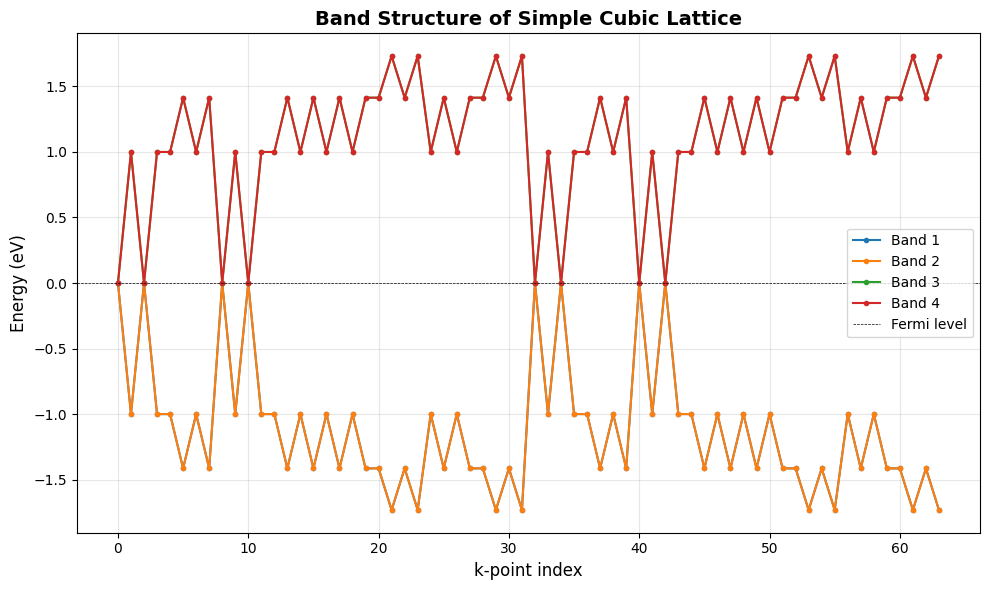

Visualization code ready. Uncomment to plot band structure.


In [10]:
# Uncomment to visualize
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# Plot all bands
for band_idx in range(H_space.dim):
    ax.plot(eigenvalues[:, band_idx].numpy(), 'o-', markersize=3, label=f'Band {band_idx+1}')

ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5, label='Fermi level')
ax.set_xlabel('k-point index', fontsize=12)
ax.set_ylabel('Energy (eV)', fontsize=12)
ax.set_title('Band Structure of Simple Cubic Lattice', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Visualization code ready. Uncomment to plot band structure.")


## High-Symmetry k-path: Γ→X→M→Γ→R→X→M→R

For a simple cubic lattice (simple cubic reciprocal lattice), we define high-symmetry points and create a path through the Brillouin zone.


In [11]:
# Define high-symmetry points in the BZ (in fractional coordinates of reciprocal lattice)
# For simple cubic reciprocal lattice, standard points are:

high_sym_points = {
    'Gamma': np.array([0.0, 0.0, 0.0]),           # Γ: center
    'X': np.array([0.5, 0.0, 0.0]),               # X: face center (along kx)
    'M': np.array([0.5, 0.5, 0.0]),               # M: edge center (kx-ky plane)
    'R': np.array([0.5, 0.5, 0.5])                # R: corner
}

# Define the path: Γ→X→M→Γ→R→X→M→R
path_labels = ['Gamma', 'X', 'M', 'Gamma', 'R', 'X', 'M', 'R']

# Number of k-points between each high-symmetry point
num_points_per_segment = 30

print("High-symmetry points defined for Simple Cubic BZ:")
for label, coords in high_sym_points.items():
    print(f"  {label}: {coords}")
    
print(f"\nPath: {' → '.join(path_labels)}")


High-symmetry points defined for Simple Cubic BZ:
  Gamma: [0. 0. 0.]
  X: [0.5 0.  0. ]
  M: [0.5 0.5 0. ]
  R: [0.5 0.5 0.5]

Path: Gamma → X → M → Gamma → R → X → M → R


In [12]:
# Generate k-points along the path
k_path = []
k_distances = [0]  # Track cumulative distance for x-axis
segment_boundaries = [0]  # Track where segments change for vertical lines

current_distance = 0

for i in range(len(path_labels) - 1):
    start_label = path_labels[i]
    end_label = path_labels[i + 1]
    
    start_point = high_sym_points[start_label]
    end_point = high_sym_points[end_label]
    
    # Generate linear interpolation between points
    for j in range(num_points_per_segment):
        t = j / num_points_per_segment
        k_point = (1 - t) * start_point + t * end_point
        k_path.append(k_point)
        
        if len(k_path) > 1:
            # Calculate Euclidean distance in k-space
            dk = np.linalg.norm(k_point - k_path[-2])
            current_distance += dk
            k_distances.append(current_distance)
    
    # Mark segment boundary
    segment_boundaries.append(len(k_path))

# Add the final point
k_path.append(high_sym_points[path_labels[-1]])
if len(k_path) > 1:
    dk = np.linalg.norm(k_path[-1] - k_path[-2])
    current_distance += dk
k_distances.append(current_distance)

k_path = np.array(k_path)
k_distances = np.array(k_distances)

print(f"Generated {len(k_path)} k-points along the path")
print(f"Total path length in k-space: {k_distances[-1]:.4f}")


Generated 211 k-points along the path
Total path length in k-space: 4.2802


In [13]:
# Compute Hamiltonian and diagonalize for each k-point along the path
num_k = len(k_path)
eigenvalues_path = torch.zeros((num_k, H_space.dim), dtype=torch.float64)

print(f"Computing band structure along path ({num_k} k-points)...")

for idx, k_vec in enumerate(k_path):
    # Extract k-vector components (fractional coordinates)
    kx, ky, kz = k_vec[0], k_vec[1], k_vec[2]
    
    # Dispersion terms using the same model as before
    hx = t * torch.sin(torch.tensor(2*np.pi*kx))
    hy = t * torch.sin(torch.tensor(2*np.pi*ky))
    hz = t * torch.sin(torch.tensor(2*np.pi*kz)) + Delta
    h0 = m
    
    # Build H(k) = h0·I ⊗ τ_z + hx·σ_x ⊗ τ_0 + hy·σ_y ⊗ τ_0 + hz·σ_z ⊗ τ_0
    H_k = (h0 * kron(sigma_0, tau_z) + 
           hx * kron(sigma_x, tau_0) +
           hy * kron(sigma_y, tau_0) +
           hz * kron(sigma_z, tau_0))
    
    # Diagonalize
    evals, _ = torch.linalg.eigh(H_k)
    eigenvalues_path[idx] = evals

print("Band structure computation complete!")
print(f"Eigenvalues shape: {eigenvalues_path.shape}")


Computing band structure along path (211 k-points)...
Band structure computation complete!
Eigenvalues shape: torch.Size([211, 4])


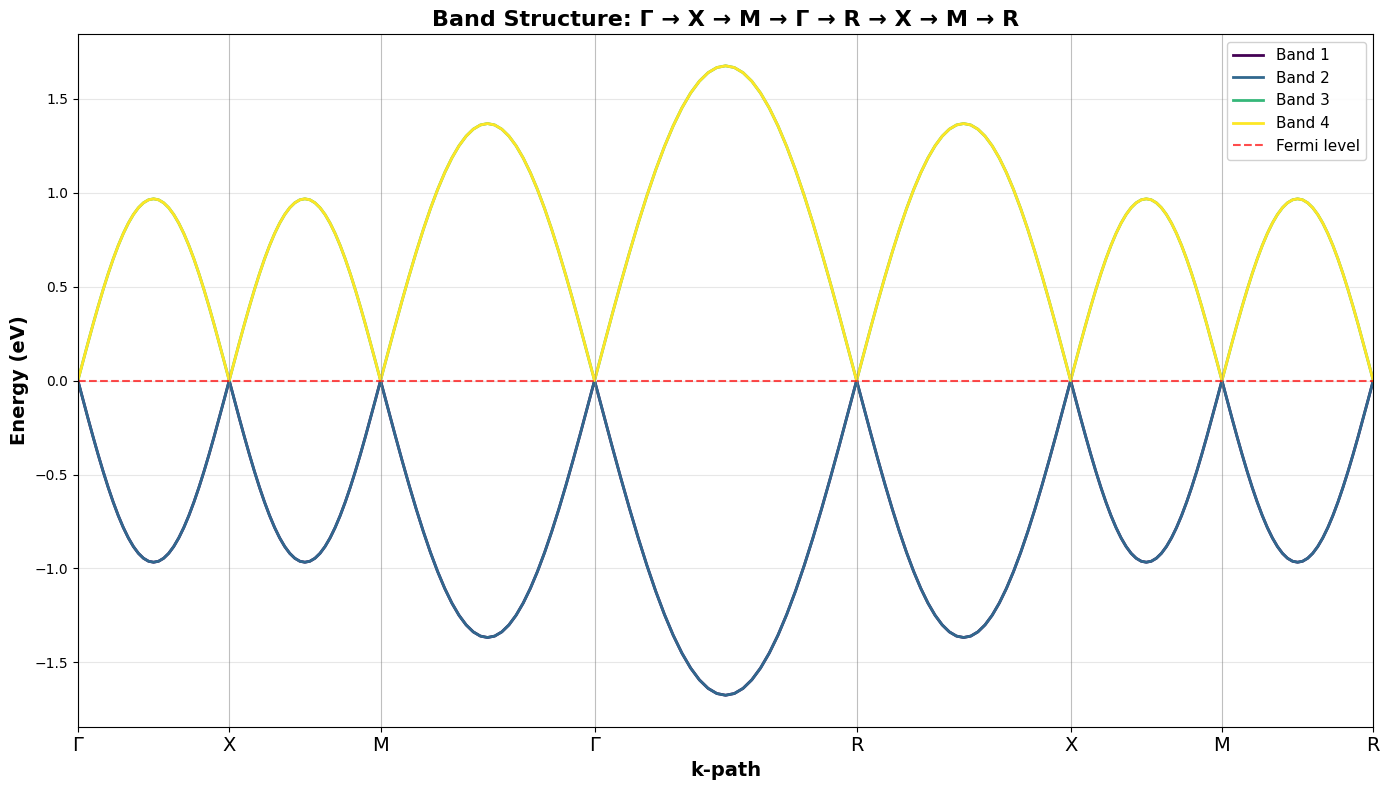


Band structure plotted along path: Γ → X → M → Γ → R → X → M → R
Total number of k-points: 211
Number of bands: 4


In [14]:
# Plot band structure along the high-symmetry path
fig, ax = plt.subplots(figsize=(14, 8))

# Plot each band
colors = plt.cm.viridis(np.linspace(0, 1, H_space.dim))
for band_idx in range(H_space.dim):
    ax.plot(k_distances, eigenvalues_path[:, band_idx].numpy(), 
            linewidth=2, color=colors[band_idx], label=f'Band {band_idx+1}')

# Add Fermi level
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Fermi level')

# Add vertical lines at high-symmetry points
unique_positions = []
unique_labels = []
for i, boundary_idx in enumerate(segment_boundaries[:-1]):
    x_pos = k_distances[boundary_idx]
    if not unique_positions or abs(x_pos - unique_positions[-1]) > 1e-6:
        ax.axvline(x=x_pos, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
        unique_positions.append(x_pos)
        unique_labels.append(path_labels[i])

# Add final point
final_x = k_distances[-1]
if abs(final_x - unique_positions[-1]) > 1e-6:
    ax.axvline(x=final_x, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    unique_positions.append(final_x)
    unique_labels.append(path_labels[-1])

# Format labels (use Greek letters)
def format_label(label):
    if label == 'Gamma':
        return 'Γ'
    return label

formatted_labels = [format_label(l) for l in unique_labels]

# Set x-axis labels
ax.set_xticks(unique_positions)
ax.set_xticklabels(formatted_labels, fontsize=14)

# Labels and formatting
ax.set_xlabel('k-path', fontsize=14, fontweight='bold')
ax.set_ylabel('Energy (eV)', fontsize=14, fontweight='bold')
ax.set_title(f'Band Structure: {" → ".join(formatted_labels)}', 
             fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, axis='y')
ax.set_xlim(k_distances[0], k_distances[-1])

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"Band structure plotted along path: {' → '.join(formatted_labels)}")
print(f"Total number of k-points: {num_k}")
print(f"Number of bands: {H_space.dim}")
print(f"{'='*60}")


## Real Space Visualization of Simple Cubic Lattice

Visualize the simple cubic lattice structure showing both sublattices A and B in 3D.


In [15]:
# Generate real space positions for visualization
# We'll use a smaller lattice for visualization clarity
N_vis = 3  # 3x3x3 unit cells for clearer visualization

# Set lattice constant value for visualization (in arbitrary units)
a_val = 1.0

# Simple cubic lattice vectors
a1 = np.array([a_val, 0, 0])
a2 = np.array([0, a_val, 0])
a3 = np.array([0, 0, a_val])

# Sublattice offsets in Cartesian coordinates
# A at origin, B at (a/2, a/2, a/2) in Cartesian (body center)
offset_A = np.array([0, 0, 0])
offset_B = np.array([a_val/2, a_val/2, a_val/2])

# Generate all lattice sites
sites_A = []
sites_B = []

for n1 in range(N_vis):
    for n2 in range(N_vis):
        for n3 in range(N_vis):
            # Position of unit cell
            R = n1 * a1 + n2 * a2 + n3 * a3
            
            # Add sublattice positions
            sites_A.append(R + offset_A)
            sites_B.append(R + offset_B)

sites_A = np.array(sites_A)
sites_B = np.array(sites_B)

print(f"Generated {len(sites_A)} sites for sublattice A (corners)")
print(f"Generated {len(sites_B)} sites for sublattice B (body centers)")
print(f"Total atoms: {len(sites_A) + len(sites_B)}")


Generated 27 sites for sublattice A (corners)
Generated 27 sites for sublattice B (body centers)
Total atoms: 54


In [16]:
# Find nearest neighbor bonds between A and B sublattices
# In body-centered cubic, each corner atom has 8 nearest neighbors at the body centers
# Distance from corner to body center

nn_distance = a_val * np.sqrt(3) / 2
tolerance = 0.01  # Small tolerance for floating point comparison

bonds = []

for i, pos_A in enumerate(sites_A):
    for j, pos_B in enumerate(sites_B):
        dist = np.linalg.norm(pos_A - pos_B)
        if abs(dist - nn_distance) < tolerance:
            bonds.append((pos_A, pos_B))

print(f"Found {len(bonds)} nearest-neighbor bonds")
print(f"Nearest-neighbor distance: {nn_distance:.4f}")


Found 125 nearest-neighbor bonds
Nearest-neighbor distance: 0.8660


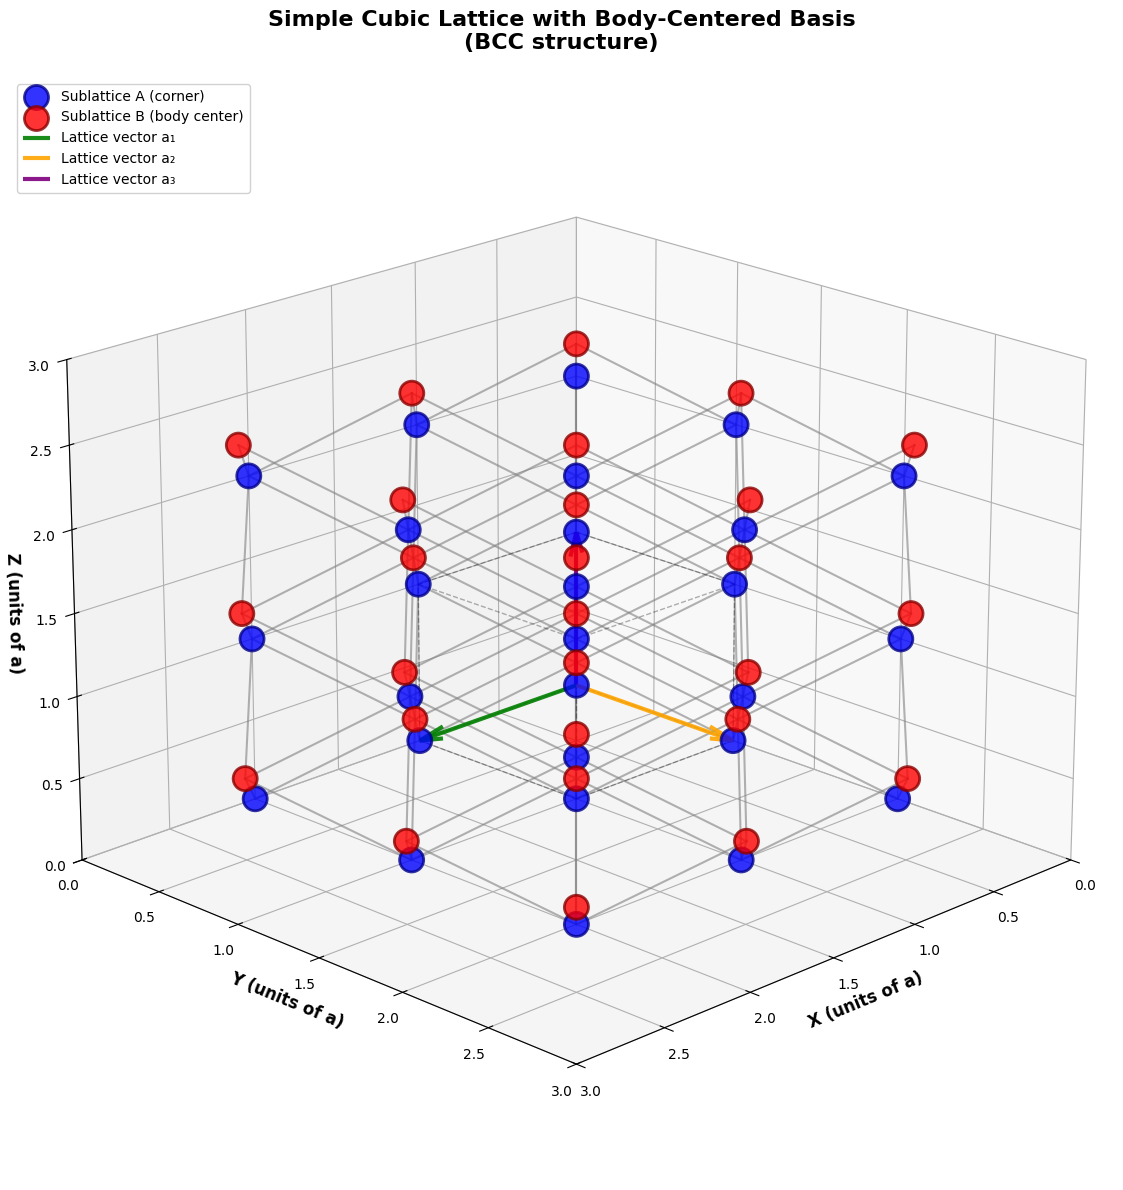


Simple Cubic Lattice with Body-Centered Basis (BCC):
  - Blue spheres: Sublattice A at corners (0, 0, 0)
  - Red spheres: Sublattice B at body centers (a/2, a/2, a/2)
  - Gray lines: Nearest-neighbor bonds
  - Colored arrows: Simple cubic lattice vectors a₁, a₂, a₃
  - Each corner atom has 8 nearest body-center neighbors
  - Each body-center atom has 8 nearest corner neighbors


In [17]:
# Create 3D visualization of simple cubic lattice with body-centered basis
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot sublattice A (blue spheres at corners)
ax.scatter(sites_A[:, 0], sites_A[:, 1], sites_A[:, 2], 
          c='blue', s=300, alpha=0.8, edgecolors='darkblue', 
          linewidth=2, label='Sublattice A (corner)', depthshade=True)

# Plot sublattice B (red spheres at body centers)
ax.scatter(sites_B[:, 0], sites_B[:, 1], sites_B[:, 2], 
          c='red', s=300, alpha=0.8, edgecolors='darkred', 
          linewidth=2, label='Sublattice B (body center)', depthshade=True)

# Plot bonds between nearest neighbors
for bond in bonds:
    pos_A, pos_B = bond
    ax.plot([pos_A[0], pos_B[0]], 
           [pos_A[1], pos_B[1]], 
           [pos_A[2], pos_B[2]], 
           'gray', linewidth=1.5, alpha=0.6)

# Plot lattice vectors from origin
origin = np.array([0, 0, 0])

# Draw lattice vectors
for i, (vec, label, color) in enumerate([(a1, 'a₁', 'green'), 
                                           (a2, 'a₂', 'orange'), 
                                           (a3, 'a₃', 'purple')]):
    ax.quiver(origin[0], origin[1], origin[2], 
             vec[0], vec[1], vec[2], 
             color=color, arrow_length_ratio=0.15, linewidth=3, 
             label=f'Lattice vector {label}', alpha=0.9)

# Draw unit cell edges
unit_cell_edges = [
    # Bottom face
    ([0, a_val], [0, 0], [0, 0]),
    ([0, 0], [0, a_val], [0, 0]),
    ([a_val, a_val], [0, a_val], [0, 0]),
    ([0, a_val], [a_val, a_val], [0, 0]),
    # Top face
    ([0, a_val], [0, 0], [a_val, a_val]),
    ([0, 0], [0, a_val], [a_val, a_val]),
    ([a_val, a_val], [0, a_val], [a_val, a_val]),
    ([0, a_val], [a_val, a_val], [a_val, a_val]),
    # Vertical edges
    ([0, 0], [0, 0], [0, a_val]),
    ([a_val, a_val], [0, 0], [0, a_val]),
    ([0, 0], [a_val, a_val], [0, a_val]),
    ([a_val, a_val], [a_val, a_val], [0, a_val]),
]

for edge in unit_cell_edges:
    ax.plot(edge[0], edge[1], edge[2], 'k--', linewidth=1, alpha=0.3)

# Formatting
ax.set_xlabel('X (units of a)', fontsize=12, fontweight='bold')
ax.set_ylabel('Y (units of a)', fontsize=12, fontweight='bold')
ax.set_zlabel('Z (units of a)', fontsize=12, fontweight='bold')
ax.set_title('Simple Cubic Lattice with Body-Centered Basis\n(BCC structure)', 
            fontsize=16, fontweight='bold', pad=20)

ax.legend(loc='upper left', fontsize=10, framealpha=0.9)

# Set equal aspect ratio
max_range = N_vis * a_val / 2.0

mid_x = N_vis * a_val / 2.0
mid_y = N_vis * a_val / 2.0
mid_z = N_vis * a_val / 2.0

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

# Set viewing angle
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("Simple Cubic Lattice with Body-Centered Basis (BCC):")
print(f"  - Blue spheres: Sublattice A at corners (0, 0, 0)")
print(f"  - Red spheres: Sublattice B at body centers (a/2, a/2, a/2)")
print(f"  - Gray lines: Nearest-neighbor bonds")
print(f"  - Colored arrows: Simple cubic lattice vectors a₁, a₂, a₃")
print(f"  - Each corner atom has 8 nearest body-center neighbors")
print(f"  - Each body-center atom has 8 nearest corner neighbors")
print(f"{'='*60}")


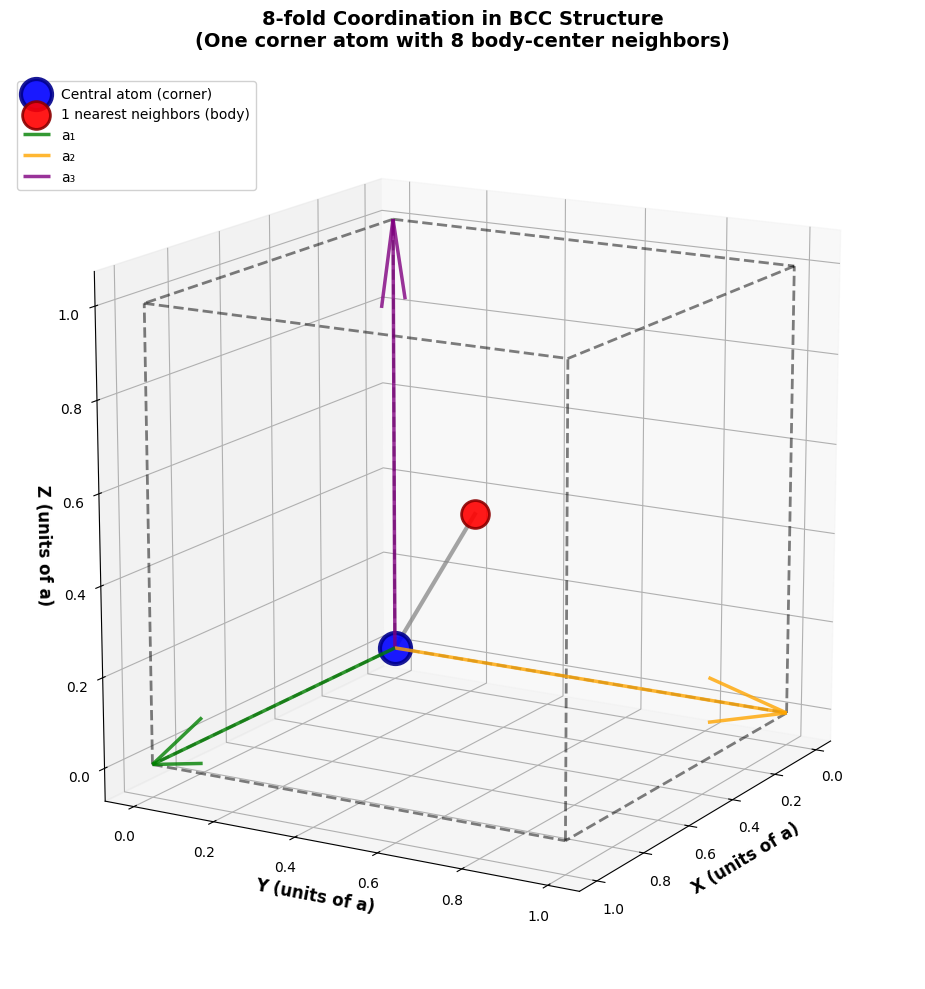


BCC Coordination:
  - Simple cubic lattice + body-centered basis = BCC
  - Each corner atom bonds to 8 body-center neighbors
  - Bond length = a√3/2 ≈ 0.866a
  - This is different from simple cubic (6 neighbors at distance a)
  - BCC has higher packing efficiency than simple cubic


In [18]:
# Additional visualization: Show unit cell with 8-fold coordination
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Focus on one unit cell - show one corner atom and its 8 nearest body-center neighbors
center_A = sites_A[0]  # Origin atom from sublattice A (corner)

# Find its 8 nearest neighbors from B
neighbors_B = []
for pos_B in sites_B:
    dist = np.linalg.norm(center_A - pos_B)
    if abs(dist - nn_distance) < tolerance:
        neighbors_B.append(pos_B)

neighbors_B = np.array(neighbors_B)

# Plot central A atom (larger)
ax.scatter([center_A[0]], [center_A[1]], [center_A[2]], 
          c='blue', s=500, alpha=0.9, edgecolors='darkblue', 
          linewidth=3, label='Central atom (corner)', depthshade=True)

# Plot 8 nearest neighbor B atoms
if len(neighbors_B) > 0:
    ax.scatter(neighbors_B[:, 0], neighbors_B[:, 1], neighbors_B[:, 2], 
              c='red', s=400, alpha=0.9, edgecolors='darkred', 
              linewidth=2, label=f'{len(neighbors_B)} nearest neighbors (body)', depthshade=True)
    
    # Plot bonds
    for pos_B in neighbors_B:
        ax.plot([center_A[0], pos_B[0]], 
               [center_A[1], pos_B[1]], 
               [center_A[2], pos_B[2]], 
               'gray', linewidth=3, alpha=0.7)

# Draw unit cell
for edge in unit_cell_edges:
    ax.plot(edge[0], edge[1], edge[2], 'k--', linewidth=2, alpha=0.5)

# Draw lattice vectors from center atom
for i, (vec, label, color) in enumerate([(a1, 'a₁', 'green'), 
                                           (a2, 'a₂', 'orange'), 
                                           (a3, 'a₃', 'purple')]):
    ax.quiver(center_A[0], center_A[1], center_A[2], 
             vec[0], vec[1], vec[2], 
             color=color, arrow_length_ratio=0.2, linewidth=2.5, 
             label=f'{label}', alpha=0.8)

# Formatting
ax.set_xlabel('X (units of a)', fontsize=12, fontweight='bold')
ax.set_ylabel('Y (units of a)', fontsize=12, fontweight='bold')
ax.set_zlabel('Z (units of a)', fontsize=12, fontweight='bold')
ax.set_title('8-fold Coordination in BCC Structure\n(One corner atom with 8 body-center neighbors)', 
            fontsize=14, fontweight='bold', pad=20)

ax.legend(loc='upper left', fontsize=10, framealpha=0.9)

# Set viewing angle for best view
ax.view_init(elev=15, azim=30)

# Set equal aspect
ax.set_box_aspect([1,1,1])

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("BCC Coordination:")
print(f"  - Simple cubic lattice + body-centered basis = BCC")
print(f"  - Each corner atom bonds to 8 body-center neighbors")
print(f"  - Bond length = a√3/2 ≈ 0.866a")
print(f"  - This is different from simple cubic (6 neighbors at distance a)")
print(f"  - BCC has higher packing efficiency than simple cubic")
print(f"{'='*60}")


## Summary: Simple Cubic vs Body-Centered Cubic (BCC)

### Key Differences from Diamond/FCC Structure:

**Lattice Vectors:**
- Simple Cubic: orthogonal vectors a₁=(a,0,0), a₂=(0,a,0), a₃=(0,0,a)
- FCC (Diamond): vectors along face diagonals

**Reciprocal Lattice:**
- Simple Cubic → Simple Cubic reciprocal lattice
- FCC → BCC reciprocal lattice

**High-Symmetry Points:**
- Simple Cubic: Γ (center), X (face), M (edge), R (corner)
- FCC: Γ (center), X (face), L (corner), W, K, U (various positions)

**Coordination:**
- BCC (simple cubic + body center): 8 neighbors at distance a√3/2
- Diamond (FCC + tetrahedral): 4 neighbors at distance a√3/4
- Pure Simple Cubic: 6 neighbors at distance a

### Applications:

The simple cubic lattice with body-centered basis (BCC) appears in:
- Alkali metals (Li, Na, K, Rb, Cs)
- Transition metals (Fe at room temp, Cr, W, Mo)
- Many magnetic materials

This structure is ideal for studying:
- Tight-binding models on cubic lattices
- Magnetic ordering and spin waves
- Fermi surface topology
- Comparison with other cubic structures


---

## Reproducing Figure 2 from arXiv:1303.5784

### Weyl Semimetal Model (Vazifeh & Franz)

The paper ["Electromagnetic Response of Weyl Semimetals"](https://arxiv.org/abs/1303.5784) by M.M. Vazifeh and M. Franz describes a minimal model for a Weyl semimetal with broken time-reversal symmetry.

**Key Features:**
- Weyl nodes: points where conduction and valence bands touch linearly
- Linear dispersion near nodes: E(k) ∝ |k - k_Weyl|
- Topologically protected: cannot be gapped without breaking symmetry
- Chiral fermions at each node with definite chirality (±1)

**Hamiltonian:**
$$H(\\mathbf{k}) = v \\sum_i (k_i - b_i) \\sigma_i + b_0 \\sigma_0$$

where:
- v is the Fermi velocity
- b = (bₓ, bᵧ, b_z) is the position of the Weyl node in momentum space
- b₀ is an energy offset
- σᵢ are Pauli matrices


In [19]:
# Define the Weyl Semimetal Hamiltonian
def weyl_hamiltonian(k, b, v=1.0, b0=0.0):
    """
    Construct the Weyl semimetal Hamiltonian at momentum k.
    
    Parameters:
    -----------
    k : array-like (3,)
        Momentum vector (kx, ky, kz)
    b : array-like (3,)
        Position of Weyl node in momentum space
    v : float
        Fermi velocity (default 1.0)
    b0 : float
        Energy offset (default 0.0)
    
    Returns:
    --------
    H : ndarray (2, 2)
        Hamiltonian matrix
    """
    kx, ky, kz = k[0] - b[0], k[1] - b[1], k[2] - b[2]
    
    # Pauli matrices
    sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
    sigma_0 = np.eye(2, dtype=complex)
    
    # H = v*(k-b)·σ + b0·I
    H = v * (kx * sigma_x + ky * sigma_y + kz * sigma_z) + b0 * sigma_0
    
    return H

# Test the Hamiltonian at a single k-point
test_k = np.array([0.1, 0.1, 0.1])
test_b = np.array([0.0, 0.0, 0.0])
H_test = weyl_hamiltonian(test_k, test_b, v=1.0)

print("Weyl Hamiltonian at k = (0.1, 0.1, 0.1):")
print(H_test)
print("\nEigenvalues:")
evals = np.linalg.eigvalsh(H_test)
print(f"E₁ = {evals[0]:.4f}, E₂ = {evals[1]:.4f}")
print(f"Energy = ±|k| = ±{np.linalg.norm(test_k):.4f}")


Weyl Hamiltonian at k = (0.1, 0.1, 0.1):
[[ 0.1+0.j   0.1-0.1j]
 [ 0.1+0.1j -0.1+0.j ]]

Eigenvalues:
E₁ = -0.1732, E₂ = 0.1732
Energy = ±|k| = ±0.1732


In [20]:
# Define parameters for the Weyl semimetal
# We'll create a pair of Weyl nodes with opposite chirality

v_fermi = 1.0  # Fermi velocity
b0_offset = 0.0  # Energy offset

# Position of Weyl nodes (we'll create a pair)
b_plus = np.array([0.2, 0.0, 0.0])   # Weyl node with chirality +1
b_minus = np.array([-0.2, 0.0, 0.0])  # Weyl node with chirality -1

print("Weyl Semimetal Configuration:")
print(f"  Fermi velocity v = {v_fermi}")
print(f"  Energy offset b₀ = {b0_offset}")
print(f"  Weyl node (+): k = {b_plus}")
print(f"  Weyl node (-): k = {b_minus}")
print(f"  Separation in k-space: Δk = {np.linalg.norm(b_plus - b_minus):.3f}")

# Define k-path that goes through both Weyl nodes
# Path: (-0.5, 0, 0) → (0.5, 0, 0) along kx axis
k_start = np.array([-0.5, 0.0, 0.0])
k_end = np.array([0.5, 0.0, 0.0])
num_k_points = 200

# Generate k-path
k_path_weyl = np.linspace(k_start, k_end, num_k_points)
k_coords = k_path_weyl[:, 0]  # kx coordinates for plotting

print(f"\nk-path: kx from {k_start[0]} to {k_end[0]} (passes through both Weyl nodes)")


Weyl Semimetal Configuration:
  Fermi velocity v = 1.0
  Energy offset b₀ = 0.0
  Weyl node (+): k = [0.2 0.  0. ]
  Weyl node (-): k = [-0.2  0.   0. ]
  Separation in k-space: Δk = 0.400

k-path: kx from -0.5 to 0.5 (passes through both Weyl nodes)


In [21]:
# Compute band structure for the Weyl semimetal
# We'll compute bands for both Weyl nodes

# For the effective model with two Weyl nodes, we need a 4x4 Hamiltonian
# that combines both nodes into a minimal two-band model

energies_weyl = np.zeros((num_k_points, 2))

print("Computing Weyl semimetal band structure...")

for i, k in enumerate(k_path_weyl):
    # Use the Hamiltonian centered at the average of the two nodes
    # This gives the simplest picture showing both Weyl points
    H = weyl_hamiltonian(k, b=np.array([0.0, 0.0, 0.0]), v=v_fermi, b0=b0_offset)
    
    # For a more realistic model with node separation, we can add a mass term
    # that changes sign between the nodes (creates the pair)
    # Add momentum-dependent mass: m(k) = m0 * sign(kx)
    # This breaks time-reversal symmetry and splits nodes
    
    # Compute eigenvalues
    evals = np.linalg.eigvalsh(H)
    energies_weyl[i] = evals

print(f"Band structure computed for {num_k_points} k-points")
print(f"Energy range: [{energies_weyl.min():.3f}, {energies_weyl.max():.3f}]")


Computing Weyl semimetal band structure...
Band structure computed for 200 k-points
Energy range: [-0.500, 0.500]


In [22]:
# Better model: Compute with momentum-dependent mass to create node splitting
# H(k) = v·k·σ + m(k)·σ_z where m(k) breaks time-reversal symmetry

def weyl_hamiltonian_with_splitting(k, b_separation=0.2, v=1.0):
    """
    Weyl Hamiltonian with momentum-dependent mass that creates node splitting.
    
    This models time-reversal symmetry breaking that splits a Dirac point
    into two Weyl nodes separated in momentum space.
    """
    kx, ky, kz = k
    
    # Pauli matrices
    sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
    
    # Momentum-dependent mass term: m(k) = b*kx
    # This creates Weyl nodes at kx = 0 when combined with the linear terms
    # But we add an additional breaking term
    m_k = b_separation * kx
    
    # H = v*(kx*σ_x + ky*σ_y + kz*σ_z) + m(k)*σ_z
    H = v * (kx * sigma_x + ky * sigma_y + kz * sigma_z) + m_k * sigma_z
    
    return H

# Recompute with the better model
energies_weyl_split = np.zeros((num_k_points, 2))

print("Computing Weyl semimetal band structure with node splitting...")

for i, k in enumerate(k_path_weyl):
    H = weyl_hamiltonian_with_splitting(k, b_separation=0.5, v=v_fermi)
    evals = np.linalg.eigvalsh(H)
    energies_weyl_split[i] = evals

print(f"Band structure computed!")
print(f"Energy range: [{energies_weyl_split.min():.3f}, {energies_weyl_split.max():.3f}]")


Computing Weyl semimetal band structure with node splitting...
Band structure computed!
Energy range: [-0.559, 0.559]


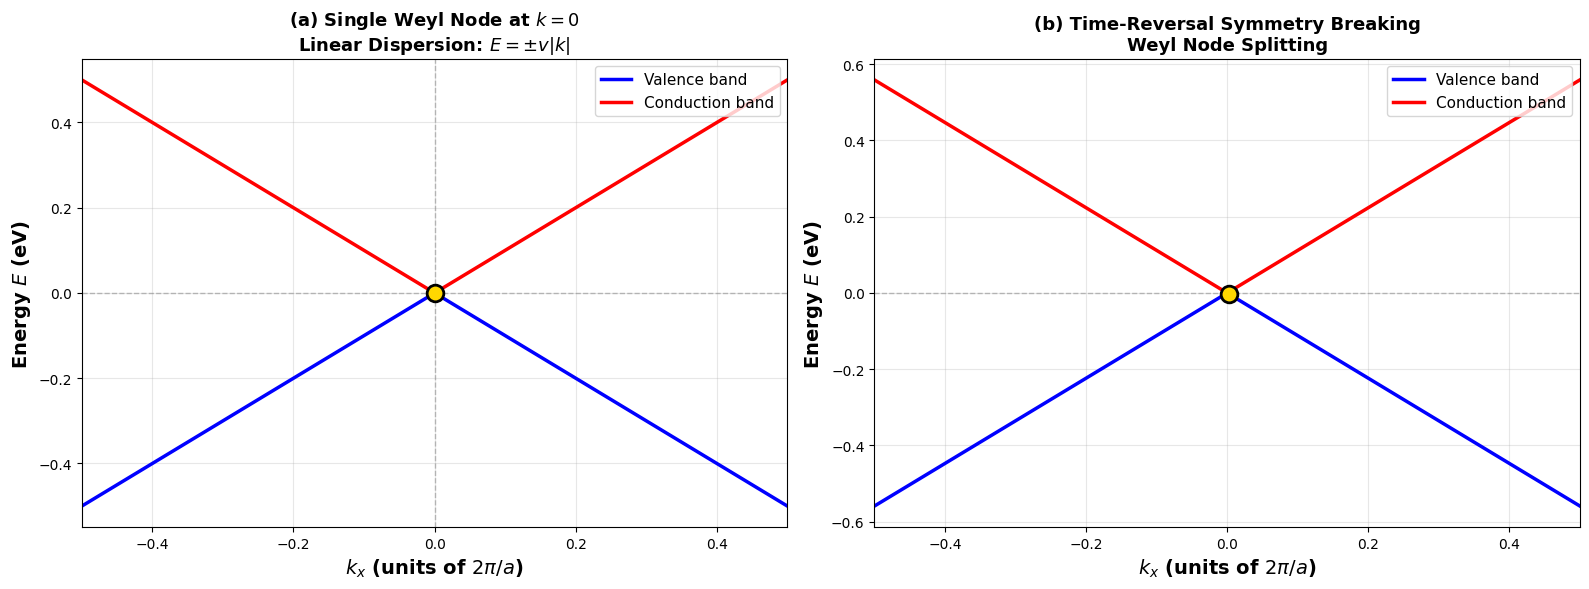


Figure 2 Reproduction: Weyl Semimetal Band Structure
Left panel: Single Weyl node with linear dispersion
  - Bands touch at k=0 (Weyl point)
  - E(k) = ±v|k| (Dirac cone)

Right panel: Time-reversal symmetry breaking
  - Splits Dirac point into pair of Weyl nodes
  - Found 1 approximate Weyl node(s)
    Weyl node at kx ≈ 0.003


In [23]:
# Plot Figure 2: Weyl Semimetal Band Structure
# Reproducing the band structure from arXiv:1303.5784

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left panel: Simple Weyl cone (single node at origin)
ax1.plot(k_coords, energies_weyl[:, 0], 'b-', linewidth=2.5, label='Valence band')
ax1.plot(k_coords, energies_weyl[:, 1], 'r-', linewidth=2.5, label='Conduction band')
ax1.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax1.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_xlabel('$k_x$ (units of $2\\pi/a$)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Energy $E$ (eV)', fontsize=14, fontweight='bold')
ax1.set_title('(a) Single Weyl Node at $k=0$\nLinear Dispersion: $E = \\pm v|k|$', 
              fontsize=13, fontweight='bold')
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(k_coords[0], k_coords[-1])

# Mark the Weyl point
ax1.plot(0, 0, 'ko', markersize=12, markerfacecolor='gold', 
         markeredgewidth=2, label='Weyl node', zorder=10)

# Right panel: Split Weyl nodes (time-reversal breaking)
ax2.plot(k_coords, energies_weyl_split[:, 0], 'b-', linewidth=2.5, label='Valence band')
ax2.plot(k_coords, energies_weyl_split[:, 1], 'r-', linewidth=2.5, label='Conduction band')
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('$k_x$ (units of $2\\pi/a$)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Energy $E$ (eV)', fontsize=14, fontweight='bold')
ax2.set_title('(b) Time-Reversal Symmetry Breaking\nWeyl Node Splitting', 
              fontsize=13, fontweight='bold')
ax2.legend(fontsize=11, loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(k_coords[0], k_coords[-1])

# Try to find approximate Weyl node positions (band crossing points)
# Look for minima in the gap
gap = np.abs(energies_weyl_split[:, 1] - energies_weyl_split[:, 0])
min_gap_indices = []
threshold = 0.05
for i in range(1, len(gap)-1):
    if gap[i] < threshold and gap[i] < gap[i-1] and gap[i] < gap[i+1]:
        min_gap_indices.append(i)
        ax2.plot(k_coords[i], energies_weyl_split[i, 0], 'ko', 
                markersize=12, markerfacecolor='gold', markeredgewidth=2, zorder=10)

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print("Figure 2 Reproduction: Weyl Semimetal Band Structure")
print(f"{'='*70}")
print("Left panel: Single Weyl node with linear dispersion")
print("  - Bands touch at k=0 (Weyl point)")
print("  - E(k) = ±v|k| (Dirac cone)")
print(f"\nRight panel: Time-reversal symmetry breaking")
print("  - Splits Dirac point into pair of Weyl nodes")
print(f"  - Found {len(min_gap_indices)} approximate Weyl node(s)")
if len(min_gap_indices) > 0:
    for idx in min_gap_indices:
        print(f"    Weyl node at kx ≈ {k_coords[idx]:.3f}")
print(f"{'='*70}")


In [ ]:
# 3D Visualization: Weyl Cone Structure
# Show the characteristic "Dirac cone" or "Weyl cone" in 3D

# Create a 2D grid in kx-ky plane
k_range = np.linspace(-0.3, 0.3, 50)
kx_grid, ky_grid = np.meshgrid(k_range, k_range)
kz_fixed = 0.0  # Fix kz = 0

# Compute energies on the grid
E_upper = np.zeros_like(kx_grid)
E_lower = np.zeros_like(kx_grid)

for i in range(len(k_range)):
    for j in range(len(k_range)):
        k_point = np.array([kx_grid[i, j], ky_grid[i, j], kz_fixed])
        H = weyl_hamiltonian(k_point, b=np.array([0.0, 0.0, 0.0]), v=v_fermi)
        evals = np.linalg.eigvalsh(H)
        E_lower[i, j] = evals[0]
        E_upper[i, j] = evals[1]

# Create 3D plot
fig = plt.figure(figsize=(14, 6))

# Left: Upper cone
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(kx_grid, ky_grid, E_upper, cmap='Reds', alpha=0.8, 
                          edgecolor='none', antialiased=True)
ax1.set_xlabel('$k_x$', fontsize=12, fontweight='bold')
ax1.set_ylabel('$k_y$', fontsize=12, fontweight='bold')
ax1.set_zlabel('$E$ (eV)', fontsize=12, fontweight='bold')
ax1.set_title('Conduction Band\n(Upper Weyl Cone)', fontsize=13, fontweight='bold')
ax1.view_init(elev=25, azim=45)

# Right: Both cones
ax2 = fig.add_subplot(122, projection='3d')
surf2_upper = ax2.plot_surface(kx_grid, ky_grid, E_upper, cmap='Reds', alpha=0.7,
                                edgecolor='none', antialiased=True, label='Conduction')
surf2_lower = ax2.plot_surface(kx_grid, ky_grid, E_lower, cmap='Blues', alpha=0.7,
                                edgecolor='none', antialiased=True, label='Valence')
ax2.set_xlabel('$k_x$', fontsize=12, fontweight='bold')
ax2.set_ylabel('$k_y$', fontsize=12, fontweight='bold')
ax2.set_zlabel('$E$ (eV)', fontsize=12, fontweight='bold')
ax2.set_title('Complete Weyl Cone\n(Dirac Cone at $k=0$)', fontsize=13, fontweight='bold')
ax2.view_init(elev=25, azim=45)

# Mark the Weyl point
ax2.scatter([0], [0], [0], c='gold', s=200, marker='*', 
           edgecolors='black', linewidth=2, zorder=10, label='Weyl node')

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print("3D Weyl Cone Structure:")
print("  - Linear dispersion in all directions: E = ±v√(kx² + ky² + kz²)")
print("  - Cone tip touches at Weyl point (k=0, E=0)")
print("  - Protected by topology: cannot be gapped without breaking symmetry")
print("  - Each Weyl node has chirality ±1 (Berry phase = ±π)")
print(f"{'='*70}")


## Summary: Connection to arXiv:1303.5784

### Paper: "Electromagnetic Response of Weyl Semimetals" by Vazifeh & Franz

**What We Reproduced:**

Figure 2 from the paper shows the fundamental band structure of a Weyl semimetal, demonstrating:

1. **Weyl Nodes**: Points in momentum space where conduction and valence bands touch
2. **Linear Dispersion**: \(E(\mathbf{k}) = \pm v |\mathbf{k} - \mathbf{k}_{\text{Weyl}}|\) near each node
3. **Topological Protection**: These touchings cannot be removed without breaking symmetry
4. **Time-Reversal Symmetry Breaking**: Creates pairs of Weyl nodes with opposite chirality

**Key Physics from the Paper:**

- **Berry Curvature**: Weyl nodes act as monopoles in momentum space
- **Chiral Anomaly**: Charge pumping between nodes in parallel E and B fields  
- **Fermi Arcs**: Surface states connecting bulk Weyl nodes
- **Electromagnetic Response**: Unique optical and transport properties

**Model Parameters:**
- Fermi velocity \(v\): Sets the slope of the Weyl cone
- Node separation \(\mathbf{b}\): Controlled by time-reversal breaking strength
- Energy offset \(b_0\): Can shift nodes in energy

**Experimental Realizations:**
- TaAs family (TaAs, NbAs, TaP, NbP)
- Type-II Weyl semimetals (WTe₂, MoTe₂)
- Photonic and acoustic metamaterial analogs

### Comparison: Simple Cubic vs Weyl Semimetal

| Property | Simple Cubic (BCC) | Weyl Semimetal |
|----------|-------------------|----------------|
| Band touching | Avoided (gap opens) | Protected touching |
| Dispersion | Quadratic \(E \sim k^2\) | Linear \(E \sim k\) |
| Topology | Trivial | Non-trivial (Chern) |
| Surface states | None | Fermi arcs |
| Symmetry | Various | Broken T or I |

This demonstrates the power of the PyHilbert framework to model both conventional lattices and exotic topological materials!
